In [72]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import axes3d

In [73]:
#primero nesesitamos crear una clase que nos cree las 100 particulas
class Particle():
    
    #constructor
    
    def __init__(self,r0,v0,a0,t,m,radius,Id,ep):
        
        #inicializamos los atributos de caa particula
        
        self.dt=t[1]-t[0]
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.L=np.zeros(len(r0))
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        self.LinealMometum=np.zeros((len(t),len(v0)))
        
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G =np.pi**2
        self.Epsi=ep
        
        
        self.rp = r0
        self.vp = v0
    
    #setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep
        
    def CheckWallLimits(self,limits,dim=3):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
                
                
                
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
        
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        # Change variables using the verlet method
        
        self.a = self.Force/self.m
        
     
        if i == 0:
            
            self.rp = self.r
            self.r = self.rp + self.dt * self.v
        
        else:
            
            self.rf = 2*self.r - self.rp + self.a * self.dt**2            
            self.v = ( self.rf - self.rp ) / (2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
            self.r = self.rf
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
        
    #Getters
    
    def GetForce(self,p):
        
        d = np.linalg.norm( (self.r - p.GetPosition())**2 + self.Epsi**2 )
        
        Fn = - self.G * self.m * p.m / d**(3/2)
        
        self.Force = np.add( self.Force, Fn* (self.r - p.GetPosition())  )
        
        self.Ep += - self.G * self.m * p.m / d**(1/2)
        
        
        
        
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.AngularMomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        #return -np.dot( self.m*self.a, self.r )
        return 0.5*self.Ep 
   


    def GetR(self):
        return self.radius
    
    
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
        

## Lo primero sera general la distribucion de puntos de radio (R) sin tomarlas como particulas de masa ni interacción alguna.


In [74]:
def createSphera(Npoints,R):
    
    X=[]
    Y=[]
    Z=[]
    
    for i in range(Npoints):
        phi=np.random.uniform(0.,2*np.pi)
        theta=np.random.uniform(0.,np.pi)
        
        u=np.random.rand()
        r=R*u**(1./3.)
        
                
        X=np.append(X, r*np.cos(phi)*np.sin(theta))
        Y=np.append(Y, r*np.sin(phi)*np.sin(theta))
        Z=np.append(Z, r*np.cos(theta))
        
    return X,Y,Z

In [75]:
Radio=1.0
Npoints=100
data_sphere=createSphera(Npoints,Radio)
data_sphere=np.array(data_sphere)

In [76]:
def coordenadas(Npoints_,Radio_):
    
    c_punto=[]
    c_pts=[]
    data=createSphera(Npoints_,Radio_)
    for i in range(len(data[0])):
        
        c_punto.append(data[0][i])
        c_punto.append(data[1][i])
        c_punto.append(data[2][i])
        
        c_pts.append(c_punto)
        c_punto=[]
        
    arr_cpts=np.array(c_pts)
    return arr_cpts

<IPython.core.display.Javascript object>


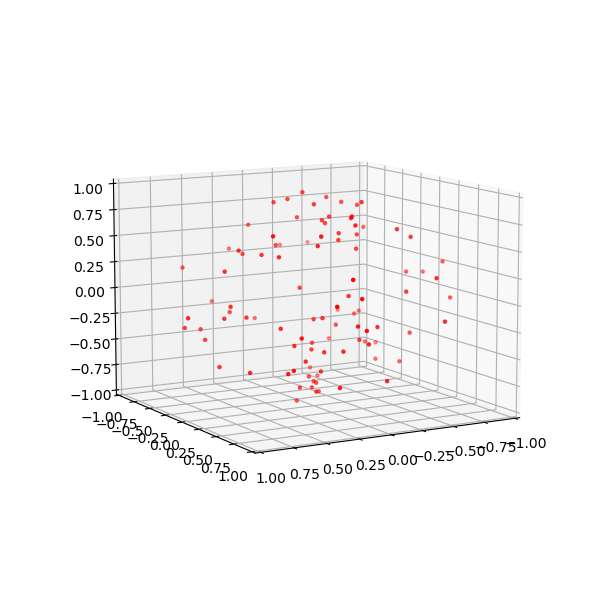

In [77]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,1,1,projection='3d')

ax.set_xlim3d(-Radio,Radio)
ax.set_ylim3d(-Radio,Radio)
ax.set_zlim3d(-Radio,Radio)

ax.view_init(10,60)
ax.scatter(data_sphere[0],data_sphere[1],data_sphere[2],color='r',marker='.')

## Ahora utilizaremos esta distribucion para generar las particulas


In [95]:
def GetParticles(Nparticles,Limit,Dim,dt):
    
    Particles_ = []
    
    posiciones=coordenadas(Nparticles,1)
    
    for i in range(Nparticles):
        
        x0 = posiciones[i]
        v0 = np.array([0,0,0])
        a0 = np.array([0,0,0])
        
        p = Particle(x0,v0,a0,t,0.01,1.0,i,0.1)
        
        Particles_.append(p)
        
    return Particles_

In [96]:
Limits = np.array([1.,1.,1.])

In [100]:
def RunSimulation(t,NParticles):

    Particles = GetParticles(NParticles,Limits[0],3,dt=dt)
      
    for it in tqdm(range(len(t))):
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             

        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
    return Particles

In [101]:
dt = 0.005
tmax = 2.
t = np.arange(0.,tmax+dt,dt)

In [102]:
Particles = RunSimulation(t,100)

100%|██████████| 401/401 [01:08<00:00,  5.88it/s]


In [103]:
EnergiaK = Particles[0].EkVector
EnergiaP = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK = np.add(EnergiaK, Particles[i].EkVector)
    EnergiaP = np.add(EnergiaP, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 

<IPython.core.display.Javascript object>


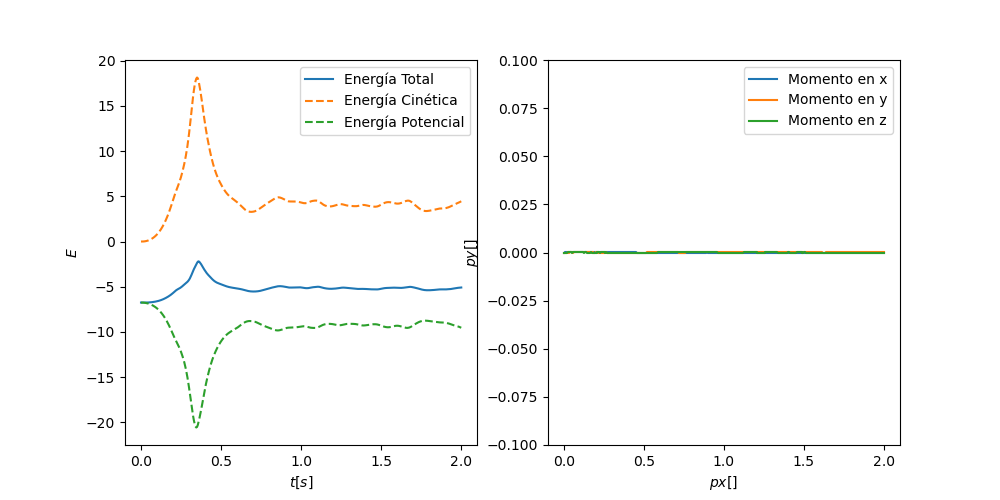

In [104]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=10)
ax1.set_ylabel(r'$E$',fontsize=10)
#ax1.set_yscale('log')
ax1.legend(loc=0)


ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], label='Momento en z')
ax2.set_xlabel(r'$px[]$',fontsize=10)
ax2.set_ylabel(r'$py[]$',fontsize=10)
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)

plt.show()

In [105]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [106]:
redt = ReduceTime(t,10)

<IPython.core.display.Javascript object>


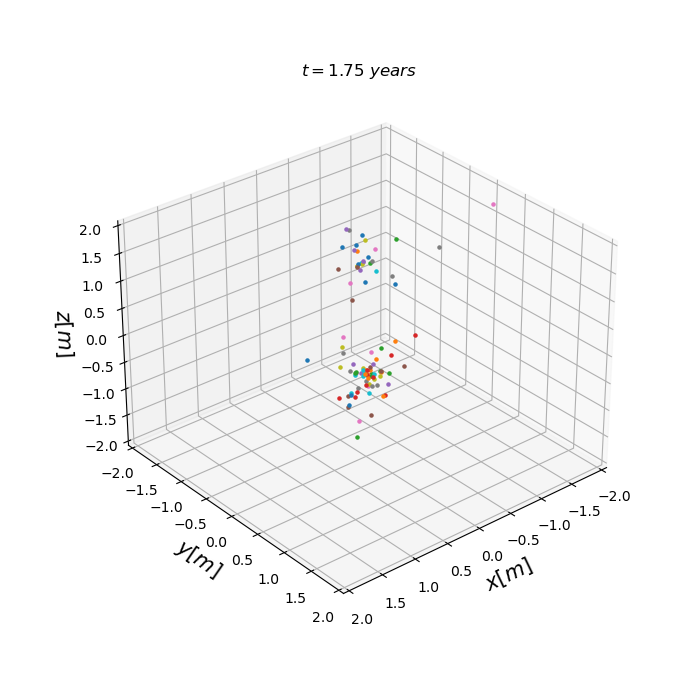

In [107]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
    ax.set_xlim(-Limits[0]-1,Limits[0]+1)
    ax.set_ylim(-Limits[1]-1,Limits[1]+1)
    ax.set_zlim(-Limits[2]-1,Limits[2]+1)



def Update(i):
    
    plot = ax.clear()
    init()
    
    j = 0
    
    for p in Particles:
           
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        vx = p.GetReduceVelocity()[i,0]
        vy = p.GetReduceVelocity()[i,1]
        vz = p.GetReduceVelocity()[i,2]
        
        plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]))
        plot = ax.scatter(x,y,z,marker='.')
        
        
            
    return plot
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

## APUNTES FINALES: 
### 1)En la grafica de conservación de enegía no logre conseguir que la energia mecanica fuera completamente constante durante el tiempo.  Se puede evidenciar que la energia cinetica es un poco mayor a la energia potencial generando asi picos y valles en la grafica de enrgía mecánica. Mi hipotesis es que esto se puede deber a que en el codigo fuente de la energia potencial agregamos un pequeño factor de correccion epsilon para que la energia no e fuera a infinito. Considero que este pequeño cambio pudo generar esa discrepansia en comparación a los resultados esperados
### 2) para la simulación de las 100 particulas, fue nesesario aumentar el paso a través del tiempo de 0.001 a 0.005 debido a que la simulación demoraba demasiado en cargar. Aun y con esta corrección , el codigo demora poco mas de un minuto en correr.